In [1]:
import sys
sys.path.append("../..")

## Proof of Concept: Block Matrix Multiply with new MTIterator2D

One performance abstraction we've seen is a `block matrix multiply`.  Here, an C = A x B has A and B decomposed into 2D blocks that are delivered in smaller chunks.  This is useful for AIE applications where there is some data reuse in the MemTile.  Below is a reference `MTIterator2D` which would allow us to reuse the A blocks while new B's are brought in


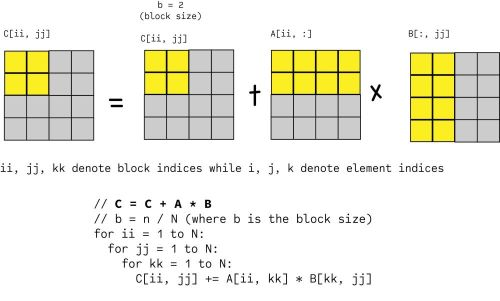

https://malithjayaweera.com/2020/07/blocked-matrix-multiplication/



In [2]:
# A reference blockmatmul kernel that would need written into C++
import numpy as np

class BlockMatMul:
    def __init__(self):
        pass
    def __call__(self,a,b,c):
        return np.dot(a,b) + c

In [3]:
# A reference MTIterator2D class that translates block slicing into 
# the underlying buffer offsets
class MTIterator2D:
    def __init__(self, origa, blocksize):
        self.a = np.copy(origa)
        self.rows = self.a.shape[0] // blocksize
        self.cols = self.a.shape[1] // blocksize
        self.bs = blocksize  

    def __getitem__(self,s):
        i, j = s
        return self.a[i*self.bs:i*self.bs+self.bs, j*self.bs:j*self.bs+self.bs]

    def __setitem__(self,s,val):
        i, j = s
        self.a[i*self.bs:i*self.bs+self.bs, j*self.bs:j*self.bs+self.bs] = val

In [4]:
# The actual application - the indexing is more complex than we
# support in Riallto v1, but shows how 2D indexing models the needed data movement
from npu.build.appbuilder import AppBuilder

class BlockMatMulApp(AppBuilder):  
    def __init__(self,blocksize):
        self.bmm = BlockMatMul()
        self.bs = blocksize
        super().__init__()

    def callgraph(self, mema, memb):
        memc = np.zeros((mema.shape[0], memb.shape[1]), dtype=np.int32)
        a, b, c = [MTIterator2D(m, self.bs) for m in [mema, memb, memc]]
        
        for i in range(a.rows):
            for j in range(b.cols):
                for k in range(a.cols):
                    c[i,j] = self.bmm(a[i, k], b[k, j], c[i, j])    

                # flatten out memc, keeping it 2D
                memc[i*self.bs:i*self.bs+self.bs, 
                     j*self.bs:j*self.bs+self.bs] = c[i,j]
        
        return memc
        

In [5]:
mema = np.random.randint(0, 10, size=(6, 6))
memb = np.random.randint(0, 10, size=(6, 6))
block_size = 2

In [6]:
bmm = BlockMatMulApp(block_size)
print(bmm(mema,memb))

[[ 88  42  63  87  57  36]
 [ 56  46  50  50  65  32]
 [111  78 102 128 101 112]
 [160  80 139 132 110  26]
 [192 155 156 178 198 115]
 [ 73  69  48  71  63  57]]


In [7]:
# quick check that results are as expected
np.array_equal(np.dot(mema,memb),bmm(mema, memb))

True